# Transfer learning Part 3: Scaling up

## Importing the data

In [ ]:
# Getting helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-07-24 13:38:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-07-24 13:38:38 (88.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
# Getting the data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-07-24 10:13:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   121MB/s    in 17s     

2025-07-24 10:13:48 (92.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# unzip_data("101_food_classes_10_percent.zip")

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test"

In [ ]:
walk_through_dir("/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and 250 images in '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/gar

In [ ]:
import tensorflow as tf

train_data_101_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=(224, 224),
                                                                                label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                label_mode='categorical',
                                                                shuffle=False) #don't shuffle the data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training Output layer with 10% of the data

In [ ]:
# Creating checkpoint callback
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_checkpoint.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal'),
  RandomRotation(0.2),
  RandomZoom(0.2),
  RandomHeight(0.2),
  RandomWidth(0.2)
], name='data_augmentation')

In [ ]:
# Setup the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
output = tf.keras.layers.Dense(101, activation='softmax', name='output_layer')(x)
model_0 = tf.keras.Model(inputs, output, name='model_0')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_0.summary()

Model: "model_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_0 = model_0.fit(train_data_101_10_percent,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.10 * len(test_data)),
                        steps_per_epoch=len(train_data_101_10_percent),
                        callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 64s 209ms/step - accuracy: 0.1583 - loss: 3.9660 - val_accuracy: 0.4569 - val_loss: 2.5933
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 181ms/step - accuracy: 0.4797 - loss: 2.3470 - val_accuracy: 0.5087 - val_loss: 2.1138
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 176ms/step - accuracy: 0.5527 - loss: 1.9154 - val_accuracy: 0.5214 - val_loss: 1.9313
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 180ms/step - accuracy: 0.5923 - loss: 1.7101 - val_accuracy: 0.5403 - val_loss: 1.8108
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.6196 - loss: 1.5452 - val_accuracy: 0.5479 - val_loss: 1.7366


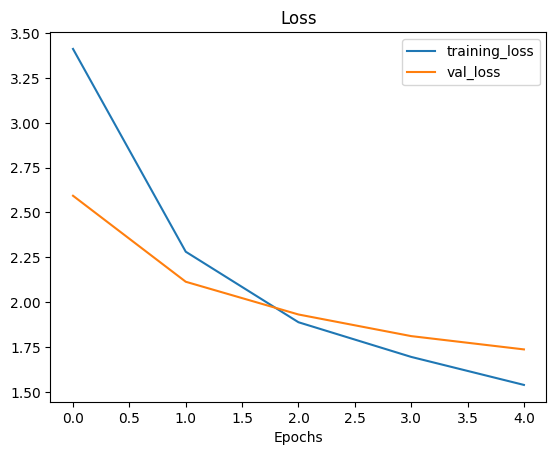

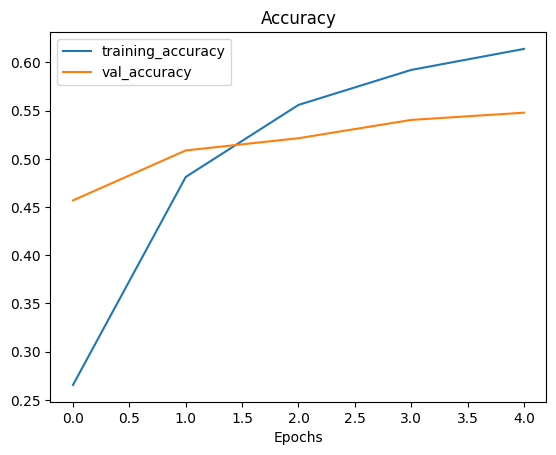

In [ ]:
plot_loss_curves(history_0)

## Fine-tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_layer False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_

In [ ]:
# Recompile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=['accuracy'])

In [ ]:
for layer in model_0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
fine_tune_epochs = 10
history_0_fine_tune = model_0.fit(train_data_101_10_percent,
                                  epochs=fine_tune_epochs,
                                  validation_data=test_data,
                                  validation_steps=int(0.10 * len(test_data)),
                                  initial_epoch=history_0.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 58s 193ms/step - accuracy: 0.6295 - loss: 1.5252 - val_accuracy: 0.5510 - val_loss: 1.7002
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 83s 199ms/step - accuracy: 0.6739 - loss: 1.3293 - val_accuracy: 0.5669 - val_loss: 1.6408
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.6883 - loss: 1.2536 - val_accuracy: 0.5763 - val_loss: 1.6069
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 141s 427ms/step - accuracy: 0.7087 - loss: 1.1796 - val_accuracy: 0.5835 - val_loss: 1.5729
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 82s 347ms/step - accuracy: 0.7355 - loss: 1.1108 - val_accuracy: 0.5945 - val_loss: 1.5547
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - accuracy: 0.7340 - loss: 1.0708 - val_accuracy: 0.5934 - val_loss: 1.5502


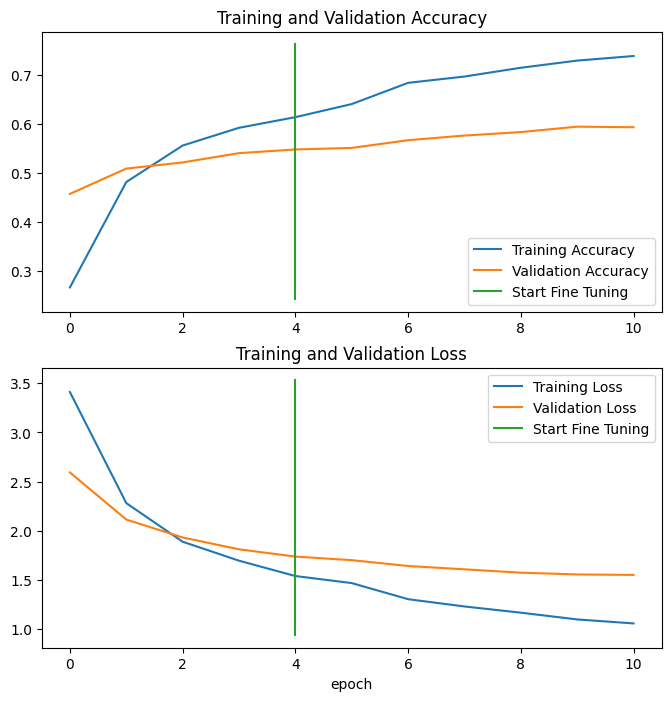

In [ ]:
compare_historys(history_0, history_0_fine_tune, initial_epochs=5)

## Save and load the model

In [ ]:
# Save the model
# model_0.save('/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_model_0.keras')

In [ ]:
# Load the saved model
import tensorflow as tf
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_model_0.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate the loaded model
# loaded_model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 99s 119ms/step - accuracy: 0.6062 - loss: 1.4897


[1.4047157764434814, 0.6240395903587341]

## Making predictions with the trained model

In [ ]:
# Make predictions
preds = loaded_model.predict(test_data, verbose=1)

790/790 ━━━━━━━━━━━━━━━━━━━━ 3431s 4s/step


In [ ]:
preds.shape

(25250, 101)

In [ ]:
preds_classes = tf.argmax(preds, axis=1)

In [ ]:
preds_classes.shape

TensorShape([25250])

In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# Unravel the test data
y_labels = []

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [ ]:
len(y_labels)

25250

In [ ]:
# One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.
# this is the model's evaluate function's output [1.4047157764434814, 0.6240395903587341]
from sklearn.metrics import accuracy_score
accuracy_score(y_labels, preds_classes)

0.624039603960396

## Let's get visual: making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

# Get a list of class_names
class_names = test_data.class_names
# make_confusion_matrix(y_labels, preds_classes, class_names, figsize=(100, 100), text_size=15)

In [ ]:
from sklearn.metrics import classification_report
# print(classification_report(y_labels, preds_classes))

In [ ]:
class_report_dict = classification_report(y_labels, preds_classes, output_dict=True)

In [ ]:
# Create dictionary for f1 score
f1_score_dict = {}

for key, value in class_report_dict.items():
  if key == 'accuracy':
    break
  else:
    f1_score_dict[key] = value['f1-score']

In [ ]:
# Sort values in an ascending order
import pandas as pd
f1_score = pd.DataFrame(f1_score_dict, index=[0]).T.sort_values(by=0, ascending=False)
f1_score

,0
33,0.964567
63,0.884532
69,0.860041
75,0.849206
65,0.847599
...,...
77,0.363636
82,0.358382
39,0.301370
0,0.291080


Text(0.5, 0, 'F1-Score')

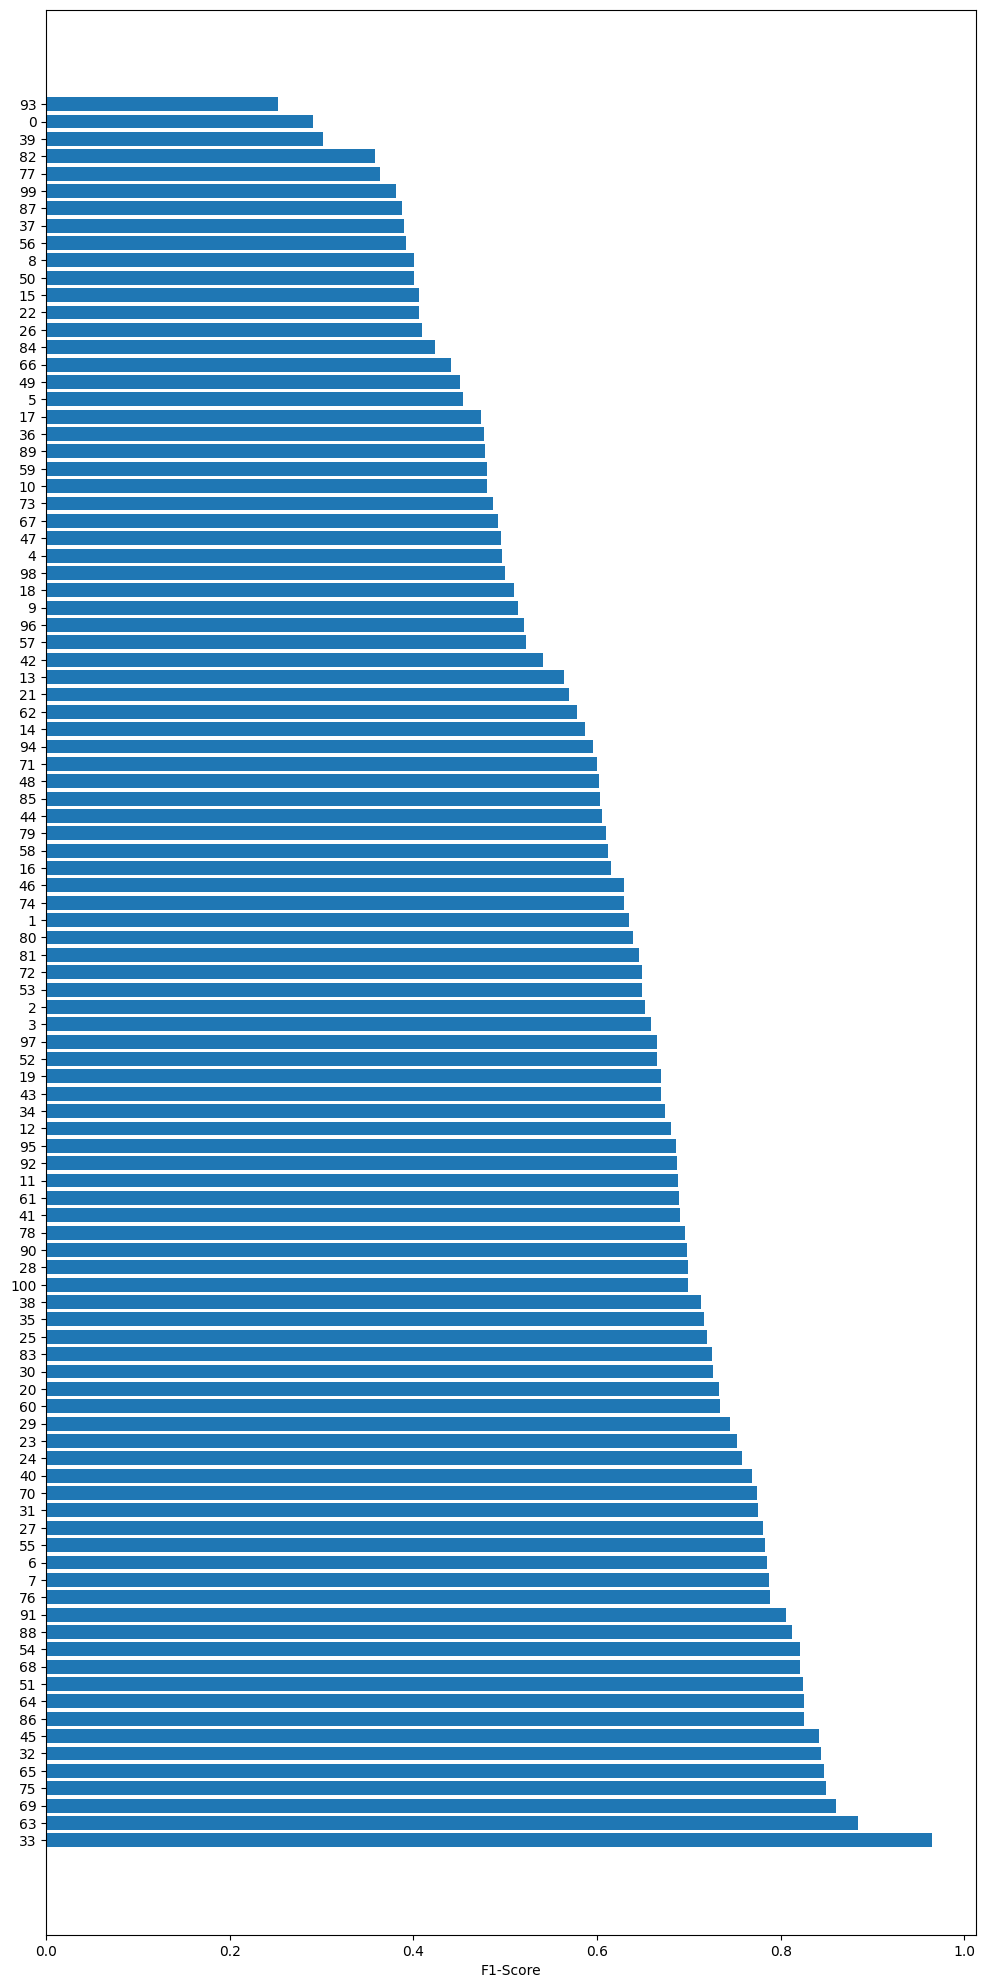

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_score)), f1_score[0].values)
ax.set_yticks(range(len(f1_score)))
ax.set_yticklabels(f1_score.index)
ax.set_xlabel('F1-Score')

## Visualizing the images

In [ ]:
def load_and_prep_image(filename, image_shape=224, scale=True):
    img = tf.io.read_file(filename)
    img = tf.io.decode_jpeg(img, channels=3)  # use decode_jpeg if your images are jpg
    img = tf.image.resize(img, [image_shape, image_shape])
    if scale:
        img = tf.cast(img, tf.float32) / 255.
    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


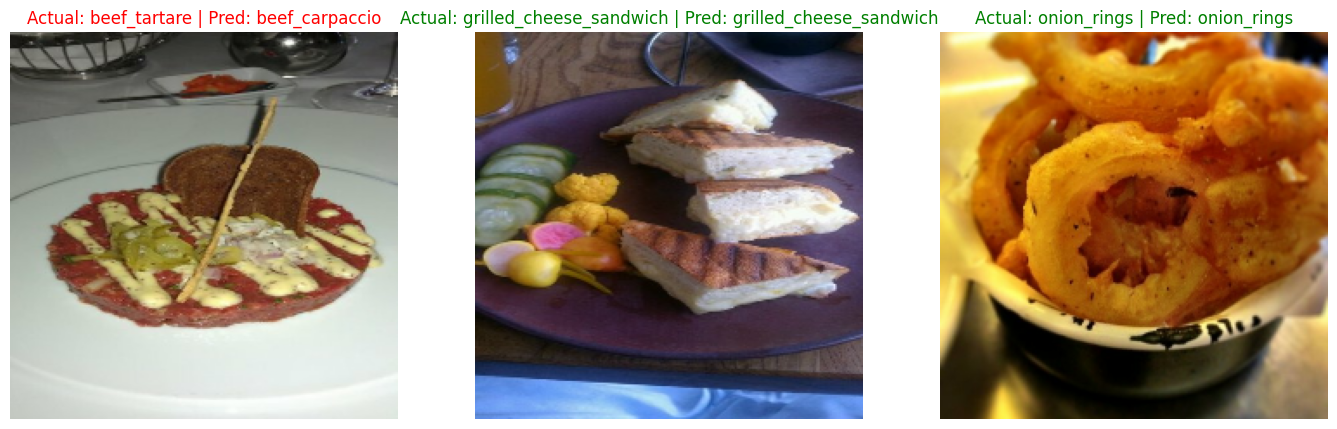

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = np.random.choice(class_names)
  filename = np.random.choice(os.listdir(os.path.join(test_dir, class_name)))
  file_path = os.path.join(test_dir, class_name, filename)
  img = load_and_prep_image(file_path, scale=False)
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f'Actual: {class_name} | Pred: {pred_class}', color=title_color)
  plt.axis(False)

In [ ]:
# Get all of the image file path in the test data
filepaths=[]
for filepath in test_data.list_files('/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/*/*.jpg',
                                     shuffle=False):
  filepaths.append(filepath.numpy())

In [ ]:
filepaths[0]

b'/content/drive/MyDrive/Colab Notebooks/Tensorflow_practice/101_food_classes_10_percent/test/apple_pie/1011328.jpg'

In [ ]:
import pandas as pd

pred_df = pd.DataFrame({'image_path':filepaths,
                        'y_true': y_labels,
                        'y_pred': preds_classes,
                        'pred_conf': preds.max(axis=1),
                        'y_true_class': [class_names[i] for i in y_labels],
                        'y_pred_class': [class_names[i] for i in preds_classes]})
pred_df.head()

,image_path,y_true,y_pred,pred_conf,y_true_class,y_pred_class
0,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,0,0,0.372362,apple_pie,apple_pie
1,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,0,0,0.940983,apple_pie,apple_pie
2,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,0,0,0.512633,apple_pie,apple_pie
3,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,0,38,0.212074,apple_pie,fish_and_chips
4,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,0,8,0.582997,apple_pie,bread_pudding


In [ ]:
pred_df['correct'] = pred_df['y_true_class'] == pred_df['y_pred_class']

In [ ]:
top_100_wrong = pred_df[pred_df['correct'] == False].sort_values('pred_conf', ascending=False)[:100]
top_100_wrong.head()

,image_path,y_true,y_pred,pred_conf,y_true_class,y_pred_class,correct
10847,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,43,68,0.996986,fried_calamari,onion_rings,False
11642,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,46,10,0.996628,garlic_bread,bruschetta,False
22,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,0,100,0.994800,apple_pie,waffles,False
18001,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,72,67,0.994082,pancakes,omelette,False
9326,b'/content/drive/MyDrive/Colab Notebooks/Tenso...,37,79,0.992446,filet_mignon,prime_rib,False


In [ ]:
# Visualize the most wrong predictions
image_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+image_to_view].itertuples()):
  img = load_and_prep_image(row.image_path, scale=False)
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  y_true_class = row.y_true_class
  y_pred_class = row.y_pred_class
  pred_conf = row.pred_conf
  plt.title(f'Actual: {y_true_class} | Pred: {y_pred_class} | Pred Conf: {pred_conf:.2f}')
  plt.axis(False)

NameError: name 'plt' is not defined